# **Final Project**

##**Problem stament :**     

The widespread dissemination of fake news and propaganda presents serious societal risks, including the erosion of public trust, political polarization, manipulation of elections, and the spread of harmful misinformation during crises such as pandemics or conflicts. From an NLP perspective, detecting fake news is fraught with challenges. Linguistically, fake news often mimics the tone and structure of legitimate journalism, making it difficult to distinguish using surface-level features. The absence of reliable and up-to-date labeled datasets, especially across multiple languages and regions, hampers the effectiveness of supervised learning models. Additionally, the dynamic and adversarial nature of misinformation means that malicious actors constantly evolve their language and strategies to bypass detection systems. Cultural context, sarcasm, satire, and implicit bias further complicate automated analysis. Moreover, NLP models risk amplifying biases present in training data, leading to unfair classifications and potential censorship of legitimate content. These challenges underscore the need for cautious, context-aware approaches, as the failure to address them can inadvertently contribute to misinformation, rather than mitigate it.



Use datasets in link : https://drive.google.com/drive/folders/1mrX3vPKhEzxG96OCPpCeh9F8m_QKCM4z?usp=sharing
to complete requirement.

## **About dataset:**

* **True Articles**:

  * **File**: `MisinfoSuperset_TRUE.csv`
  * **Sources**:

    * Reputable media outlets like **Reuters**, **The New York Times**, **The Washington Post**, etc.

* **Fake/Misinformation/Propaganda Articles**:

  * **File**: `MisinfoSuperset_FAKE.csv`
  * **Sources**:

    * **American right-wing extremist websites** (e.g., Redflag Newsdesk, Breitbart, Truth Broadcast Network)
    * **Public dataset** from:

      * Ahmed, H., Traore, I., & Saad, S. (2017): "Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques" *(Springer LNCS 10618)*



## **Requirement**

A team consisting of three members must complete a project that involves applying the methods learned from the beginning of the course up to the present. The team is expected to follow and document the entire machine learning workflow, which includes the following steps:

1. **Data Preprocessing**: Clean and prepare the dataset,etc.

2. **Exploratory Data Analysis (EDA)**: Explore and visualize the data.

3. **Model Building**: Select and build one or more machine learning models suitable for the problem at hand.

4. **Hyperparameter set up**: Set and adjust the model's hyperparameters using appropriate methods to improve performance.

5. **Model Training**: Train the model(s) on the training dataset.

6. **Performance Evaluation**: Evaluate the trained model(s) using appropriate metrics (e.g., accuracy, precision, recall, F1-score, confusion matrix, etc.) and validate their performance on unseen data.

7. **Conclusion**: Summarize the results, discuss the model's strengths and weaknesses, and suggest possible improvements or future work.





#Library

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout,
    Input, Concatenate, GlobalMaxPooling1D, BatchNormalization
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from torch.optim import AdamW
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
true_data = pd.read_csv("/content/drive/MyDrive/DataSet_Misinfo_TRUE.csv")
fake_data = pd.read_csv("/content/drive/MyDrive/DataSet_Misinfo_FAKE.csv")

#Data Preprocessing

In [ ]:
true_data['label'] = 1
fake_data['label'] = 0

In [ ]:
data = pd.concat([true_data, fake_data], ignore_index=True)

In [ ]:
print(data.isnull().sum())

Unnamed: 0     0
text          29
label          0
dtype: int64


In [ ]:
data = data[data['text'].notna() & (data['text'].str.strip() != '')]

In [ ]:
# Làm sạch văn bản
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
cleaned_texts = []

for text in data['text']:
    if not isinstance(text, str):
        cleaned_texts.append('')
        continue
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    cleaned_texts.append(' '.join(tokens))

data['cleaned_text'] = cleaned_texts
data = data[data['cleaned_text'] != '']

Phân bố lớp:
label
0    43594
1    34944
Name: count, dtype: int64


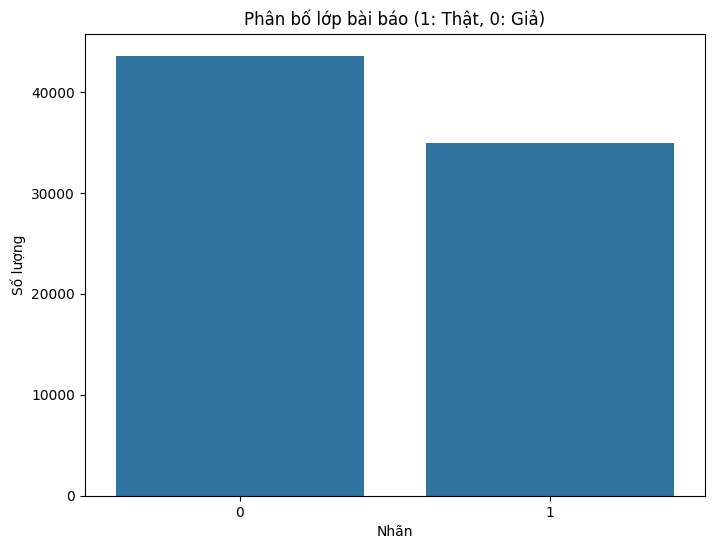

In [ ]:
# 3. Kiểm tra mất cân bằng lớp
class_counts = data['label'].value_counts()
print("Phân bố lớp:")
print(class_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data)
plt.title('Phân bố lớp bài báo (1: Thật, 0: Giả)')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.show()

In [ ]:
# 4. Vector hóa với TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data['cleaned_text'])
y = data['label'].values

In [ ]:
# 5. Chia dữ liệu (cho TF-IDF)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_tfidf, y, test_size=0.1, random_state=42, stratify=y
)
val_size_adjusted = 0.1 / (0.8 + 0.1)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_size_adjusted, random_state=42, stratify=y_temp
)

# In kích thước các tập
print("Kích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập kiểm định:", X_val.shape)
print("Kích thước tập kiểm tra:", X_test.shape)

Kích thước tập huấn luyện: (62830, 5000)
Kích thước tập kiểm định: (7854, 5000)
Kích thước tập kiểm tra: (7854, 5000)


In [ ]:
#Xử lý imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
# 5. Token hóa cho BERT
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_length = 128
input_ids = []
attention_masks = []

for text in data['cleaned_text']:
    encoding = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='np'
    )
    input_ids.append(encoding['input_ids'][0])
    attention_masks.append(encoding['attention_mask'][0])

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)
y_bert = data['label'].values

#Exploratory Data Analysis

In [ ]:
data.head()

,Unnamed: 0,text,label,cleaned_text
0,0,The head of a conservative Republican faction ...,1,head conservative republican faction u congres...
1,1,Transgender people will be allowed for the fir...,1,transgender people allowed first time enlist u...
2,2,The special counsel investigation of links bet...,1,special counsel investigation link russia pres...
3,3,Trump campaign adviser George Papadopoulos tol...,1,trump campaign adviser george papadopoulos tol...
4,4,President Donald Trump called on the U.S. Post...,1,president donald trump called u postal service...


In [ ]:
df = data.copy()


=== LABEL DISTRIBUTION ===
label
0    43594
1    34944
Name: count, dtype: int64
Label balance ratio: 0.80


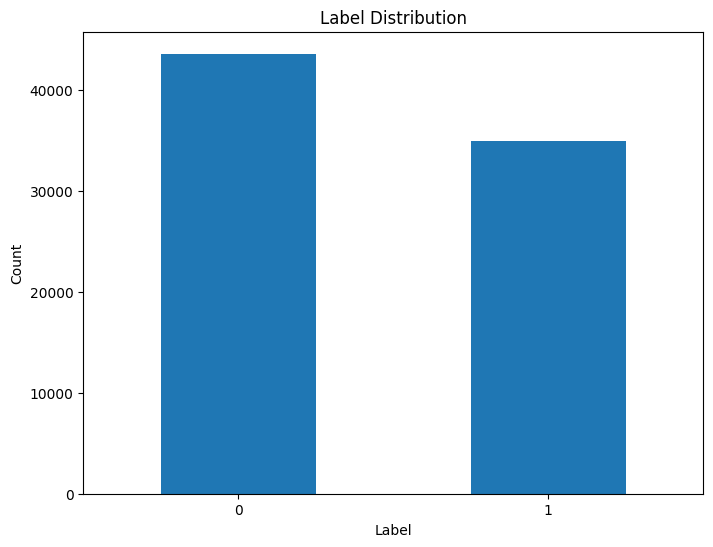

In [ ]:
print("\n=== LABEL DISTRIBUTION ===")
label_counts = df['label'].value_counts()
print(label_counts)
print(f"Label balance ratio: {label_counts.min()/label_counts.max():.2f}")

plt.figure(figsize=(8, 6))
data['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()



=== TEXT LENGTH ANALYSIS ===
Original text length - Mean: 2898.48, Std: 3661.44
Cleaned text length - Mean: 1961.22, Std: 2408.47
Word count - Mean: 479.71, Std: 613.42


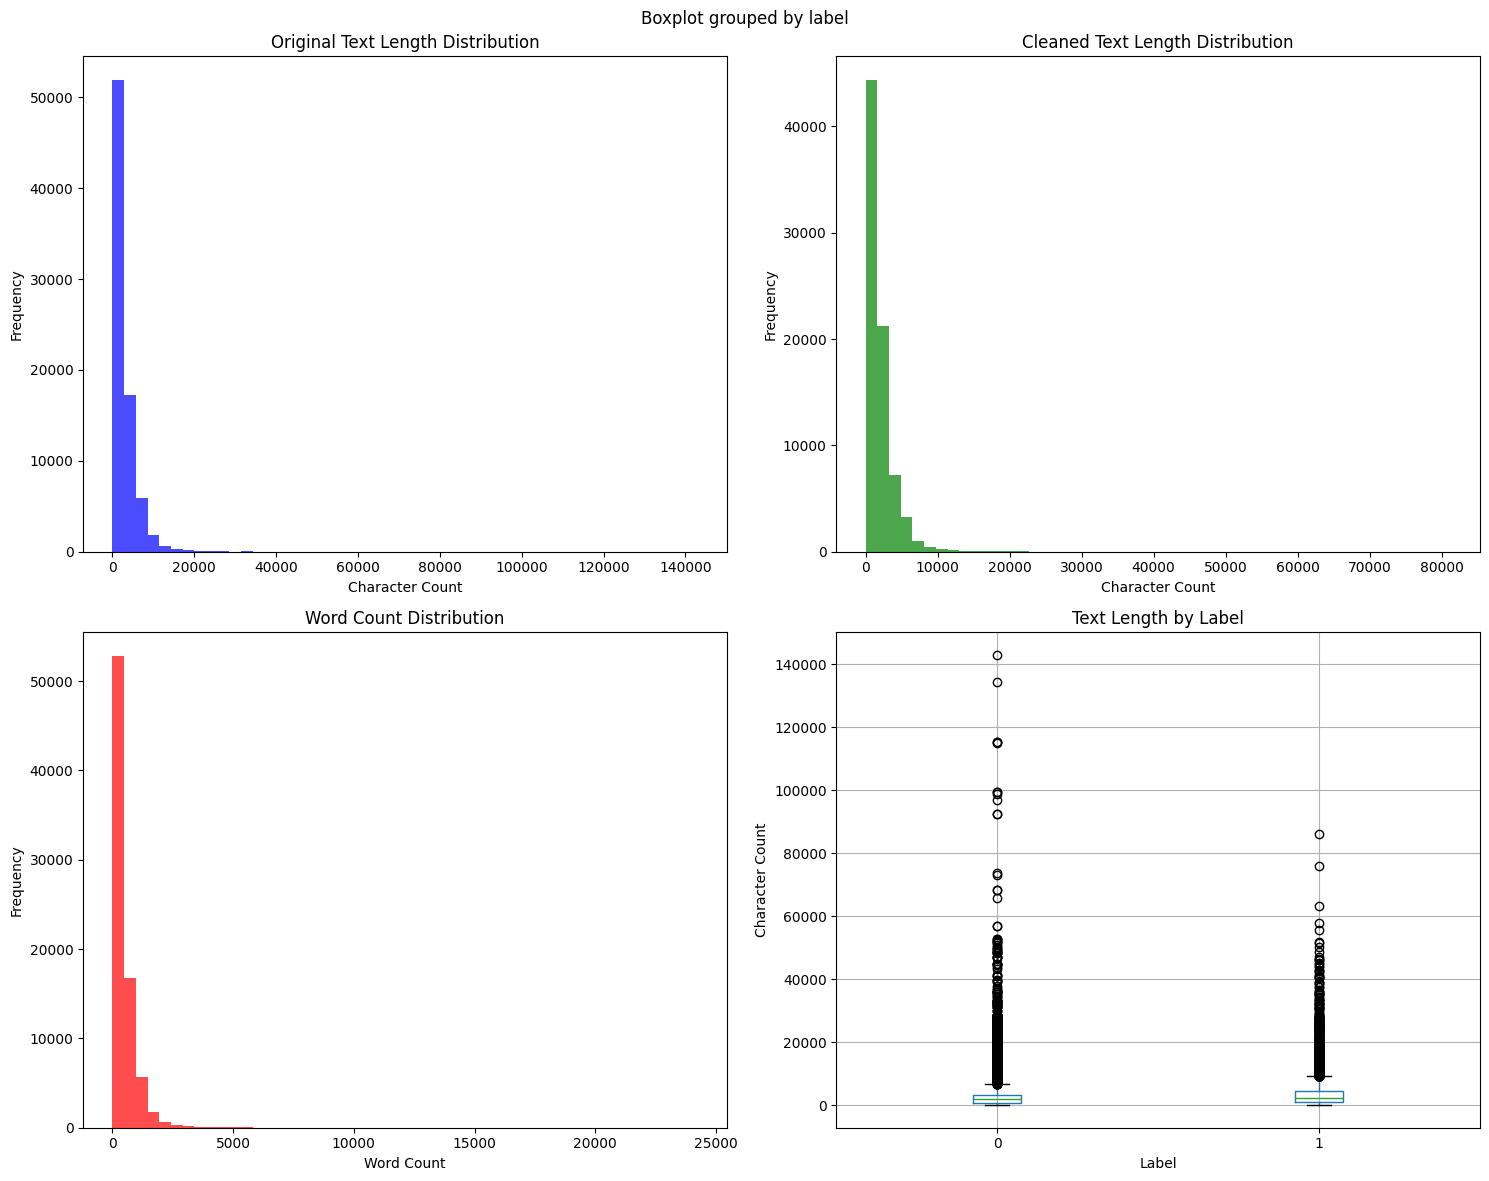

In [ ]:
print("\n=== TEXT LENGTH ANALYSIS ===")
df['text_length'] = df['text'].str.len()
df['cleaned_text_length'] = df['cleaned_text'].str.len()
df['word_count'] = df['text'].str.split().str.len()
df['cleaned_word_count'] = df['cleaned_text'].str.split().str.len()

print(f"Original text length - Mean: {df['text_length'].mean():.2f}, Std: {df['text_length'].std():.2f}")
print(f"Cleaned text length - Mean: {df['cleaned_text_length'].mean():.2f}, Std: {df['cleaned_text_length'].std():.2f}")
print(f"Word count - Mean: {df['word_count'].mean():.2f}, Std: {df['word_count'].std():.2f}")

# Plot text length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Text length histogram
axes[0,0].hist(df['text_length'], bins=50, alpha=0.7, color='blue')
axes[0,0].set_title('Original Text Length Distribution')
axes[0,0].set_xlabel('Character Count')
axes[0,0].set_ylabel('Frequency')

# Cleaned text length histogram
axes[0,1].hist(df['cleaned_text_length'], bins=50, alpha=0.7, color='green')
axes[0,1].set_title('Cleaned Text Length Distribution')
axes[0,1].set_xlabel('Character Count')
axes[0,1].set_ylabel('Frequency')

# Word count histogram
axes[1,0].hist(df['word_count'], bins=50, alpha=0.7, color='red')
axes[1,0].set_title('Word Count Distribution')
axes[1,0].set_xlabel('Word Count')
axes[1,0].set_ylabel('Frequency')

# Text length by label
df.boxplot(column='text_length', by='label', ax=axes[1,1])
axes[1,1].set_title('Text Length by Label')
axes[1,1].set_xlabel('Label')
axes[1,1].set_ylabel('Character Count')

plt.tight_layout()
plt.show()



=== VOCABULARY ANALYSIS ===
Top 20 words in original text:
the: 2163185
to: 1065404
of: 964087
and: 881688
a: 855298
in: 730858
that: 504314
is: 371861
for: 350851
on: 347609
it: 255536
he: 248205
with: 243243
was: 238222
as: 227984
said: 214556
by: 192161
his: 181579
s: 181224
be: 173636

Top 20 words in cleaned text:
said: 214556
trump: 197858
state: 106260
u: 103549
would: 99796
people: 88012
one: 86205
president: 84804
mr: 77946
clinton: 72523
year: 72431
new: 67339
time: 64241
also: 62110
republican: 56771
like: 55741
american: 52093
government: 49278
say: 47799
could: 47318


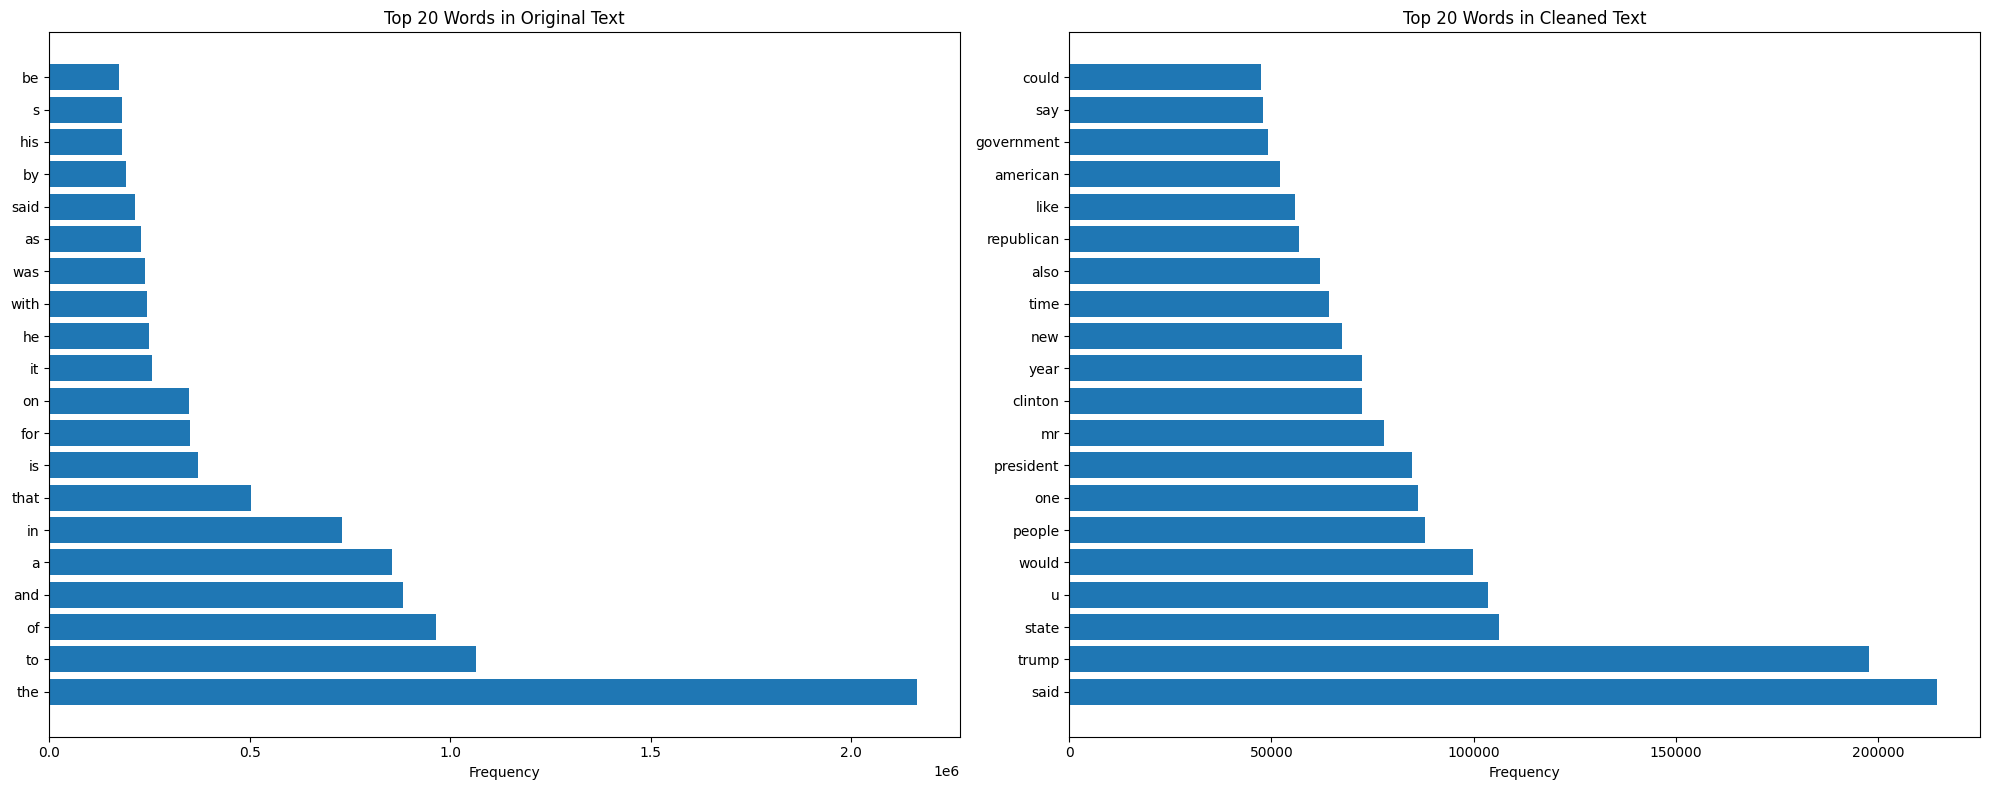

In [ ]:
# 4. VOCABULARY
from collections import Counter
print("\n=== VOCABULARY ANALYSIS ===")

# Function to get word frequencies
def get_word_freq(text_series, n_top=20):
    all_words = ' '.join(text_series.astype(str)).lower().split()
    # Remove basic punctuation
    all_words = [re.sub(r'[^a-zA-Z]', '', word) for word in all_words]
    all_words = [word for word in all_words if len(word) > 0]
    return Counter(all_words).most_common(n_top)

# Overall word frequencies
top_words_original = get_word_freq(df['text'])
top_words_cleaned = get_word_freq(df['cleaned_text'])

print("Top 20 words in original text:")
for word, freq in top_words_original:
    print(f"{word}: {freq}")

print("\nTop 20 words in cleaned text:")
for word, freq in top_words_cleaned:
    print(f"{word}: {freq}")

# Plot top words
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Original text top words
words_orig, freqs_orig = zip(*top_words_original)
axes[0].barh(words_orig, freqs_orig)
axes[0].set_title('Top 20 Words in Original Text')
axes[0].set_xlabel('Frequency')

# Cleaned text top words
words_clean, freqs_clean = zip(*top_words_cleaned)
axes[1].barh(words_clean, freqs_clean)
axes[1].set_title('Top 20 Words in Cleaned Text')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# 5. WORD FREQUENCY BY LABEL
print("\n=== WORD FREQUENCY BY LABEL ===")
for label in df['label'].unique():
    print(f"\nTop words for label {label}:")
    label_text = df[df['label'] == label]['cleaned_text']
    top_words_label = get_word_freq(label_text, 15)
    for word, freq in top_words_label:
        print(f"{word}: {freq}")



=== WORD FREQUENCY BY LABEL ===

Top words for label 1:
said: 167521
trump: 97059
mr: 70710
state: 63156
would: 56640
u: 52160
president: 47294
year: 42544
one: 40476
new: 38788
people: 38781
republican: 35615
also: 33399
time: 30234
government: 28112

Top words for label 0:
trump: 100799
u: 51389
people: 49231
said: 47035
one: 45729
clinton: 45688
would: 43156
state: 43104
president: 37510
time: 34007
like: 31954
hillary: 30799
american: 30133
year: 29887
also: 28711


In [ ]:
# 9. TEXT COMPARISON (Original vs Cleaned)
print("\n=== TEXT COMPARISON ===")
df['compression_ratio'] = df['cleaned_text_length'] / df['text_length']
print(f"Average compression ratio: {df['compression_ratio'].mean():.2f}")
print(f"Text reduction: {(1 - df['compression_ratio'].mean()) * 100:.1f}%")


=== TEXT COMPARISON ===
Average compression ratio: 0.69
Text reduction: 31.4%


In [ ]:
print("\n=== SUMMARY STATISTICS ===")
summary_stats = {
    'Total Samples': len(df),
    'Unique Texts': df['text'].nunique(),
    'Average Text Length': df['text_length'].mean(),
    'Average Word Count': df['word_count'].mean(),
    'Labels': df['label'].nunique(),
    'Class Balance': df['label'].value_counts().min() / df['label'].value_counts().max()
}

for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")


=== SUMMARY STATISTICS ===
Total Samples: 78538
Unique Texts: 68555
Average Text Length: 2898.48
Average Word Count: 479.71
Labels: 2
Class Balance: 0.80


#Model Building

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_resampled, y_train_resampled)
Accuracy = logreg.score(X_test, y_test)
print(Accuracy*100)

93.5064935064935


In [ ]:
X = "The French government announced a national day of mourning after the attack, and President Emmanuel Macron expressed solidarity with the victims during a press conference in Paris."
encoding = tokenizer(
    X,
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors='np'
)


X_transformed = vectorizer.transform([X])

prediction_proba_logreg = logreg.predict_proba(X_transformed)

probability_true_logreg = prediction_proba_logreg[0][1]

if probability_true_logreg >= 0.5:
    print("This news is True")
else:
    print("This news is False")


This news is True


In [ ]:
X = "Aliens have landed in Germany and established a new world order, claims anonymous source from social media."
encoding = tokenizer(
    X,
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors='np'
)


X_transformed = vectorizer.transform([X])

prediction_proba_logreg = logreg.predict_proba(X_transformed)

probability_true_logreg = prediction_proba_logreg[0][1]

if probability_true_logreg >= 0.5:
    print("This news is True")
else:
    print("This news is False")

This news is False


Naive-Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(X_train_resampled, y_train_resampled)
Accuracy = NB.score(X_test, y_test)
print(Accuracy*100)

85.00127323656736


In [ ]:
X = "The French government announced a national day of mourning after the attack, and President Emmanuel Macron expressed solidarity with the victims during a press conference in Paris."
encoding = tokenizer(
    X,
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors='np'
)


X_transformed = vectorizer.transform([X])

prediction_proba_NB = NB.predict_proba(X_transformed)

probability_true_NB = prediction_proba_NB[0][1]

if probability_true_NB >= 0.5:
    print("This news is True")
else:
    print("This news is False")


This news is True


In [ ]:
X = "Aliens have landed in Germany and established a new world order, claims anonymous source from social media."
encoding = tokenizer(
    X,
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors='np'
)


X_transformed = vectorizer.transform([X])

prediction_proba_NB = NB.predict_proba(X_transformed)

probability_true_NB = prediction_proba_NB[0][1]

if probability_true_NB >= 0.5:
    print("This news is True")
else:
    print("This news is False")


This news is False


#CNN + LSTM (Keras)

##Hyperparameter set up

In [ ]:
# Cấu hình tham số
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100
BATCH_SIZE = 32
EPOCHS = 10

##Data Preprocessing

In [ ]:
# Tokenization cho CNN + LSTM
print("Đang thực hiện tokenization...")
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(data['cleaned_text'])

Đang thực hiện tokenization...


In [ ]:
# Chuyển đổi text thành sequences
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])
X_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y_sequences = data['label'].values

print(f"Vocab size: {len(tokenizer.word_index)}")
print(f"Shape của X_sequences: {X_sequences.shape}")

Vocab size: 313703
Shape của X_sequences: (78538, 200)


In [ ]:
# Chia dữ liệu cho CNN + LSTM
X_temp_seq, X_test_seq, y_temp_seq, y_test_seq = train_test_split(
    X_sequences, y_sequences, test_size=0.1, random_state=42, stratify=y_sequences
)
val_size_adjusted = 0.1 / (0.8 + 0.1)
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_temp_seq, y_temp_seq, test_size=val_size_adjusted, random_state=42, stratify=y_temp_seq
)

print("Kích thước tập dữ liệu cho CNN + LSTM:")
print(f"Train: {X_train_seq.shape}, Val: {X_val_seq.shape}, Test: {X_test_seq.shape}")

Kích thước tập dữ liệu cho CNN + LSTM:
Train: (62830, 200), Val: (7854, 200), Test: (7854, 200)


In [ ]:
# Xử lý class imbalance với class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weight_dict}")

Class weights: {0: np.float64(0.9007885304659499), 1: np.float64(1.123770345197639)}


##Model Training

In [ ]:
# Định nghĩa mô hình CNN + LSTM
def create_cnn_lstm_model(vocab_size, embedding_dim, max_length):
    """
    Tạo mô hình CNN + LSTM cho phân loại fake news
    """
    model = Sequential()

    # Embedding layer
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, name='embedding'))

    # CNN layers
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name='conv1d_1'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool1d_1'))
    model.add(Dropout(0.3, name='dropout_1'))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name='conv1d_2'))
    model.add(MaxPooling1D(pool_size=2, name='maxpool1d_2'))
    model.add(Dropout(0.3, name='dropout_2'))

    # LSTM layers
    model.add(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, name='lstm_1'))
    model.add(LSTM(50, dropout=0.3, recurrent_dropout=0.3, name='lstm_2'))

    # Dense layers
    model.add(Dense(64, activation='relu', name='dense_1'))
    model.add(BatchNormalization(name='batch_norm'))
    model.add(Dropout(0.5, name='dropout_3'))
    model.add(Dense(32, activation='relu', name='dense_2'))
    model.add(Dropout(0.3, name='dropout_4'))

    # Output layer
    model.add(Dense(1, activation='sigmoid', name='output'))

    return model

# Tạo và compile model
print("Đang tạo mô hình CNN + LSTM...")
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
print(f"Vocab size được sử dụng: {vocab_size}")

Đang tạo mô hình CNN + LSTM...
Vocab size được sử dụng: 20000


In [ ]:
model = create_cnn_lstm_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH
)

# Build model bằng cách truyền input shape
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

In [ ]:
# In thông tin mô hình
print("\nKiến trúc mô hình:")
model.summary()


Kiến trúc mô hình:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 198, 128)       │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_1 (MaxPooling1D)      │ (None, 99, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 99, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 97, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1d_2 (MaxPooling1D)      │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 48, 100)        │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,165,001 (8.26 MB)

 Trainable params: 2,164,873 (8.26 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

In [ ]:
# Training
print("\nBắt đầu training...")
history = model.fit(
    X_train_seq, y_train_seq,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_seq, y_val_seq),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Bắt đầu training...
Epoch 1/10
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 730s 365ms/step - accuracy: 0.7454 - loss: 0.4841 - precision: 0.7062 - recall: 0.7447 - val_accuracy: 0.9242 - val_loss: 0.2077 - val_precision: 0.9021 - val_recall: 0.9308 - learning_rate: 0.0010
Epoch 2/10
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 708s 351ms/step - accuracy: 0.9354 - loss: 0.1906 - precision: 0.9271 - recall: 0.9277 - val_accuracy: 0.9481 - val_loss: 0.1490 - val_precision: 0.9317 - val_recall: 0.9531 - learning_rate: 0.0010
Epoch 3/10
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 745s 352ms/step - accuracy: 0.9684 - loss: 0.1020 - precision: 0.9617 - recall: 0.9669 - val_accuracy: 0.9410 - val_loss: 0.1963 - val_precision: 0.9021 - val_recall: 0.9731 - learning_rate: 0.0010
Epoch 4/10
1964/1964 ━━━━━━━━━━━━━━━━━━━━ 741s 352ms/step - accuracy: 0.9803 - loss: 0.0655 - precision: 0.9768 - recall: 0.9789 - val_accuracy: 0.9523 - val_loss: 0.1632 - val_precision: 0.9462 - val_recall: 0.9465 - learning_rate: 0.0010
Epoch 5/10
1964/196

In [ ]:
# Đánh giá mô hình
print("\n" + "="*50)
print("ĐÁNH GIÁ MÔ HÌNH CNN + LSTM")
print("="*50)


ĐÁNH GIÁ MÔ HÌNH CNN + LSTM


In [ ]:
# Dự đoán trên tập test
test_predictions = model.predict(X_test_seq)
test_pred_binary = (test_predictions > 0.5).astype(int).flatten()

246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step


##Performance Evaluation

In [ ]:
# Tính toán metrics
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test_seq, y_test_seq, verbose=0)
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {f1_score:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_seq, test_pred_binary, target_names=['Fake', 'Real']))

Test Accuracy: 0.9481
Test Precision: 0.9303
Test Recall: 0.9548
Test F1-Score: 0.9424

Classification Report:
              precision    recall  f1-score   support

        Fake       0.96      0.94      0.95      4360
        Real       0.93      0.95      0.94      3494

    accuracy                           0.95      7854
   macro avg       0.95      0.95      0.95      7854
weighted avg       0.95      0.95      0.95      7854



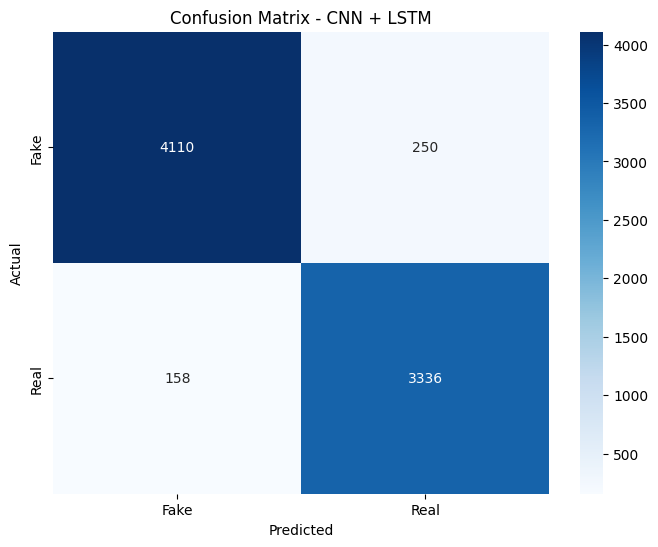

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_seq, test_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix - CNN + LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

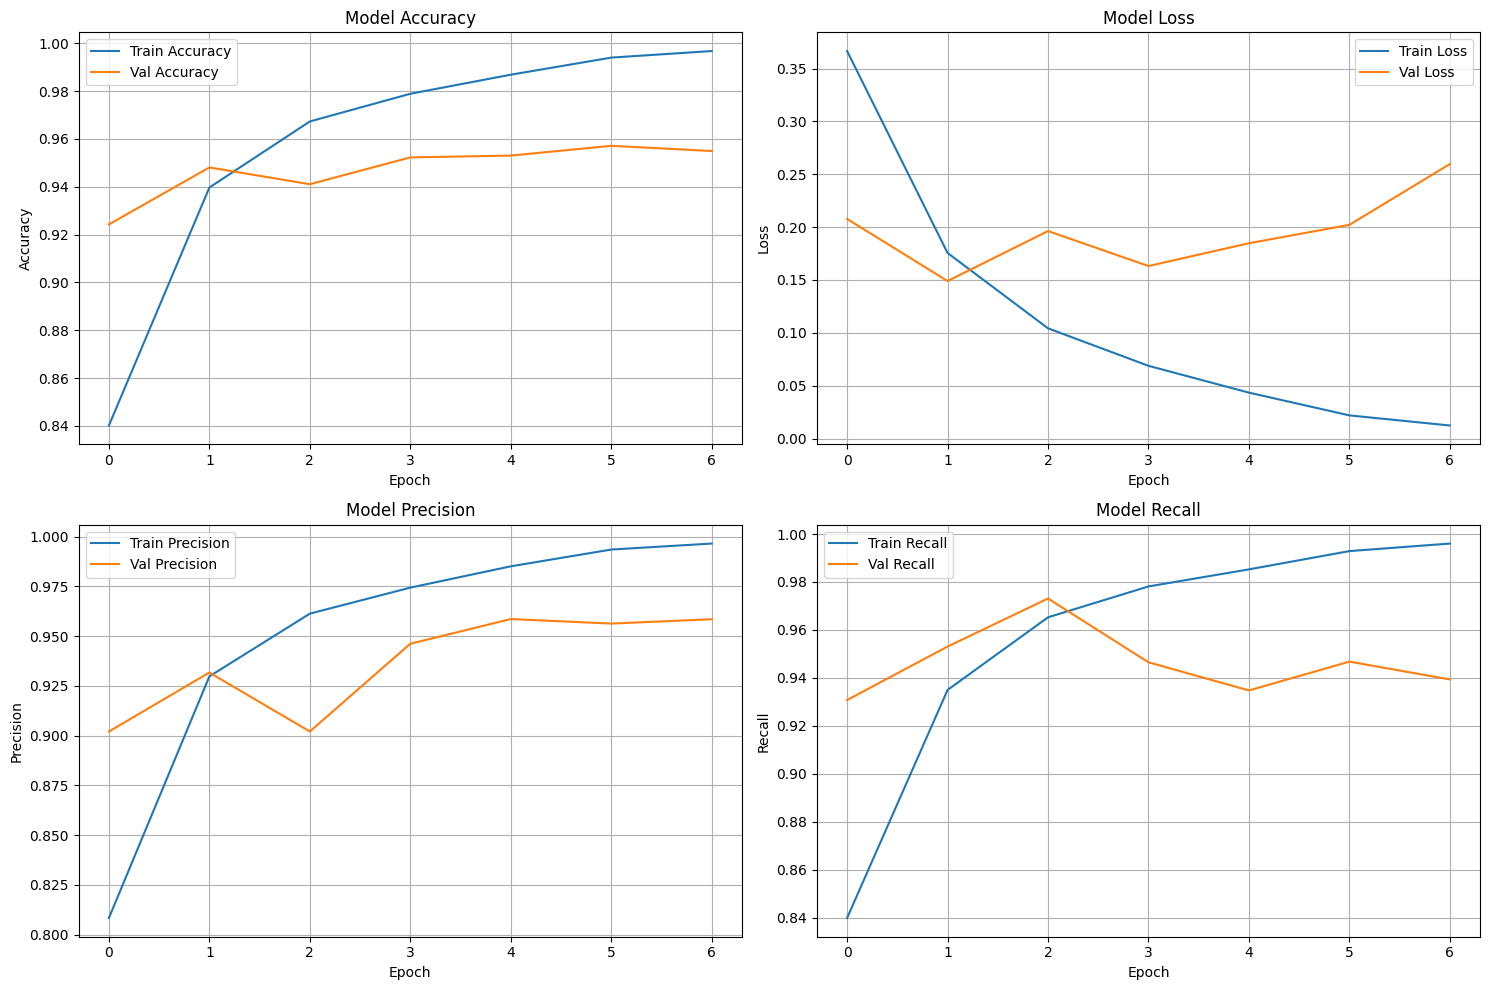

In [ ]:
# Vẽ biểu đồ training history
def plot_training_history(history):
    """Vẽ biểu đồ quá trình training"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
def predict_news(text, model, tokenizer, max_length=MAX_SEQUENCE_LENGTH):
    """
    Dự đoán một bài báo là thật hay giả
    """
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    cleaned_text = ' '.join(tokens)

    # Tokenize và padding
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Dự đoán
    prediction = model.predict(padded_sequence)[0][0]

    return {
        'prediction': prediction,
        'label': 'Real' if prediction > 0.5 else 'Fake',
        'confidence': prediction if prediction > 0.5 else 1 - prediction
    }


In [ ]:
sample_text = "Breaking news: Scientists discover new planet in our solar system"
result = predict_news(sample_text, model, tokenizer)
print(f"\nVí dụ dự đoán:")
print(f"Text: {sample_text}")
print(f"Prediction: {result['label']} (confidence: {result['confidence']:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

Ví dụ dự đoán:
Text: Breaking news: Scientists discover new planet in our solar system
Prediction: Fake (confidence: 0.9917)


In [ ]:
# Lưu model
model.save('cnn_lstm_fake_news_model.h5')
print("\nMô hình đã được lưu vào 'cnn_lstm_fake_news_model.h5'")


Mô hình đã được lưu vào 'cnn_lstm_fake_news_model.h5'


In [ ]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer đã được lưu vào 'tokenizer.pkl'")

print("\n" + "="*50)


Tokenizer đã được lưu vào 'tokenizer.pkl'



#BERT

In [ ]:
# Thiết lập device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 1. Tạo Dataset class cho BERT
class FakeNewsDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
# 2. Chia dữ liệu cho BERT
from sklearn.model_selection import train_test_split

# Chia dữ liệu với tỷ lệ 80:10:10
X_temp_ids, X_test_ids, X_temp_masks, X_test_masks, y_temp_bert, y_test_bert = train_test_split(
    input_ids, attention_masks, y_bert, test_size=0.1, random_state=42, stratify=y_bert
)

val_size_adjusted = 0.1 / (0.8 + 0.1)
X_train_ids, X_val_ids, X_train_masks, X_val_masks, y_train_bert, y_val_bert = train_test_split(
    X_temp_ids, X_temp_masks, y_temp_bert, test_size=val_size_adjusted, random_state=42, stratify=y_temp_bert
)

print("Kích thước dữ liệu BERT:")
print(f"Train: {X_train_ids.shape[0]}")
print(f"Validation: {X_val_ids.shape[0]}")
print(f"Test: {X_test_ids.shape[0]}")

Kích thước dữ liệu BERT:
Train: 62830
Validation: 7854
Test: 7854


In [ ]:
# 3. Tạo DataLoader
batch_size = 16

train_dataset = FakeNewsDataset(X_train_ids, X_train_masks, y_train_bert)
val_dataset = FakeNewsDataset(X_val_ids, X_val_masks, y_val_bert)
test_dataset = FakeNewsDataset(X_test_ids, X_test_masks, y_test_bert)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# 4. Định nghĩa mô hình BERT
class BertForFakeNews(nn.Module):
    def __init__(self, model_name='bert-base-uncased', num_classes=2, dropout_rate=0.4):
        super(BertForFakeNews, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


In [ ]:
# 5. Khởi tạo mô hình
model = BertForFakeNews()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForFakeNews(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
# 6. Thiết lập optimizer và scheduler
epochs = 10
learning_rate = 1e-5
warmup_steps = 0

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [ ]:
# 7. Hàm train
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(data_loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct_predictions/total_predictions:.4f}'
        })

    return total_loss / len(data_loader), correct_predictions / total_predictions


In [ ]:
# 8. Hàm đánh giá
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(logits, labels)

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(data_loader)

    return avg_loss, accuracy, all_predictions, all_labels

In [ ]:
# 9. Training loop
from tqdm.auto import tqdm
print("Bắt đầu training...")
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Early stopping parameters
best_val_loss = float('inf')
best_val_accuracy = 0
best_model_state = None
patience = 2
patience_counter = 0


for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    print('-' * 50)

    # Training
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    val_loss, val_acc, _, _ = evaluate_model(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Lưu mô hình tốt nhất (dựa trên validation accuracy)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict().copy()
        print(f'✅ New best model saved! Val Acc: {val_acc:.4f}')

    # Early stopping logic (dựa trên validation loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        print(f'✅ Validation loss improved: {val_loss:.4f}')
    else:
        patience_counter += 1
        print(f'⚠️ Validation loss didn\'t improve. Patience: {patience_counter}/{patience}')

        if patience_counter >= patience:
            print(f'🛑 Early stopping triggered! No improvement for {patience} epochs.')
            print(f'Best validation accuracy: {best_val_accuracy:.4f}')
            break



Bắt đầu training...

Epoch 1/10
--------------------------------------------------


Training:   0%|          | 0/3927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/491 [00:00<?, ?it/s]

Train Loss: 0.1672, Train Acc: 0.9439
Val Loss: 0.1233, Val Acc: 0.9640
✅ New best model saved! Val Acc: 0.9640
✅ Validation loss improved: 0.1233

Epoch 2/10
--------------------------------------------------


Training:   0%|          | 0/3927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/491 [00:00<?, ?it/s]

Train Loss: 0.0770, Train Acc: 0.9807
Val Loss: 0.1403, Val Acc: 0.9720
✅ New best model saved! Val Acc: 0.9720
⚠️ Validation loss didn't improve. Patience: 1/2

Epoch 3/10
--------------------------------------------------


Training:   0%|          | 0/3927 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/491 [00:00<?, ?it/s]

Train Loss: 0.0400, Train Acc: 0.9911
Val Loss: 0.1256, Val Acc: 0.9789
✅ New best model saved! Val Acc: 0.9789
⚠️ Validation loss didn't improve. Patience: 2/2
🛑 Early stopping triggered! No improvement for 2 epochs.
Best validation accuracy: 0.9789


In [ ]:
# 10. Load mô hình tốt nhất và đánh giá trên test set
if best_model_state:
    model.load_state_dict(best_model_state)

print("\nĐánh giá trên test set...")
test_loss, test_acc, test_predictions, test_labels = evaluate_model(model, test_loader, device)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')


Đánh giá trên test set...


Evaluating:   0%|          | 0/491 [00:00<?, ?it/s]

Test Loss: 0.1353
Test Accuracy: 0.9791


In [ ]:
# 11. Báo cáo chi tiết
print("\nBáo cáo phân loại:")
print(classification_report(test_labels, test_predictions,
                          target_names=['Fake News', 'Real News']))


Báo cáo phân loại:
              precision    recall  f1-score   support

   Fake News       0.98      0.99      0.98      4360
   Real News       0.98      0.97      0.98      3494

    accuracy                           0.98      7854
   macro avg       0.98      0.98      0.98      7854
weighted avg       0.98      0.98      0.98      7854



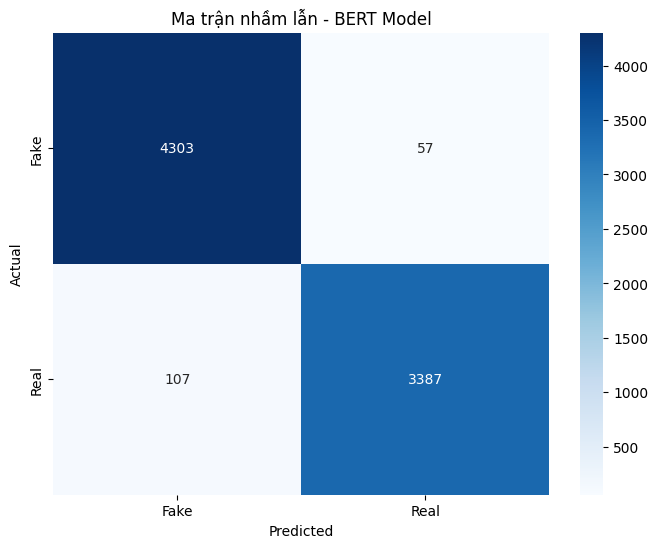

In [ ]:
# 12. Ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_labels, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Ma trận nhầm lẫn - BERT Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

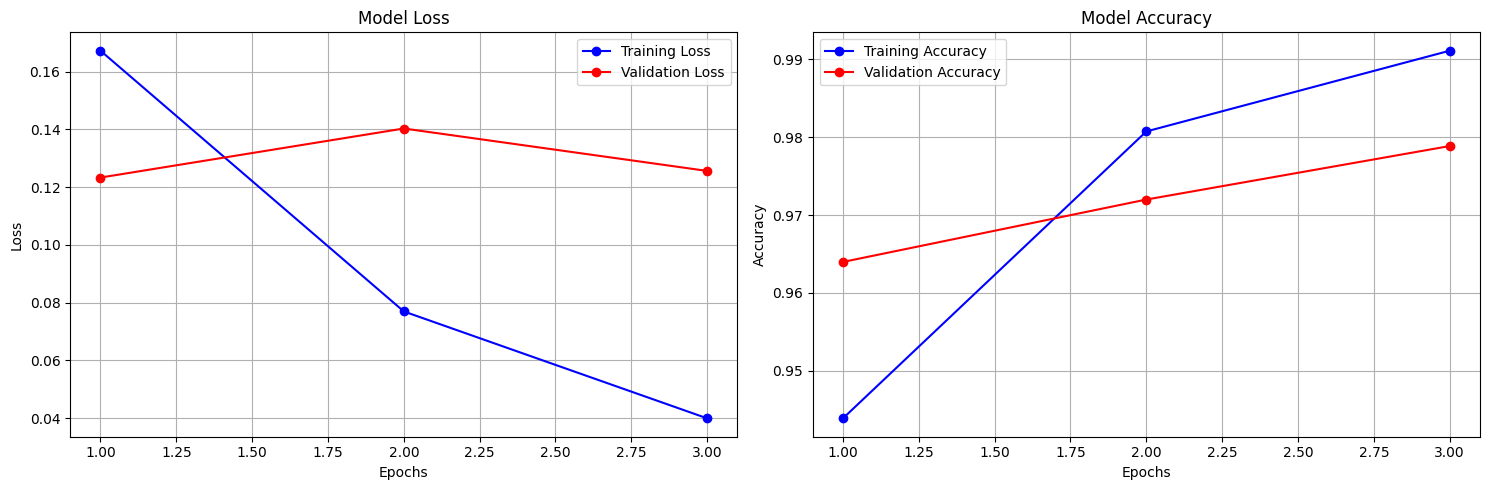

In [ ]:
# 13. Vẽ biểu đồ loss và accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

num_epochs_trained = len(train_losses)
epochs_range = range(1, num_epochs_trained + 1) # Use the actual number of epochs

# Loss
ax1.plot(epochs_range, train_losses, 'bo-', label='Training Loss')
ax1.plot(epochs_range, val_losses, 'ro-', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(epochs_range, train_accuracies, 'bo-', label='Training Accuracy')
ax2.plot(epochs_range, val_accuracies, 'ro-', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 14. Lưu mô hình
torch.save({
    'model_state_dict': best_model_state,
    'tokenizer': tokenizer,
    'max_length': max_length,
    'test_accuracy': test_acc
}, 'bert_fake_news_model.pth')

print(f"\nMô hình đã được lưu với accuracy: {test_acc:.4f}")


Mô hình đã được lưu với accuracy: 0.9791


In [ ]:
# 15. Hàm dự đoán cho văn bản mới
def predict_news(text, model, tokenizer, device, max_length=128):
    model.eval()

    # Tiền xử lý văn bản giống như training data
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    encoding = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1).cpu().numpy()[0]
        confidence = probabilities.max().cpu().numpy()

    label = "Real News" if prediction == 1 else "Fake News"
    return label, confidence

# Ví dụ sử dụng
sample_text = "Breaking news: Scientists discover new species in Amazon rainforest"
prediction, confidence = predict_news(sample_text, model, tokenizer, device)
print(f"\nVí dụ dự đoán:")
print(f"Text: {sample_text}")
print(f"Prediction: {prediction}")
print(f"Confidence: {confidence:.4f}")


Ví dụ dự đoán:
Text: Breaking news: Scientists discover new species in Amazon rainforest
Prediction: Fake News
Confidence: 0.9998


#Conclusion

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import pickle

print("\n" + "="*50)
print("KẾT LUẬN DỰ ÁN PHÁT HIỆN TIN GIẢ")
print("="*50)

print("\n### Vấn đề đặt ra:")
print("- **Sự lan truyền của tin giả:** Sự bùng nổ của mạng xã hội và internet đã làm gia tăng tốc độ phát tán của các thông tin sai lệch, gây ảnh hưởng nghiêm trọng đến nhận thức cộng đồng, chính trị, y tế và an ninh xã hội.")
print("Nên ta ứng dụng NLP - nhánh nhỏ của Machine learning để dự đoán fake news")


print("\n### Tóm tắt kết quả:")
print(" - Đầu tiên ta import các thư viện và dataset để training (DataSet_Misinfo_TRUE.csv và DataSet_Misinfo_FAKE.csv) ")
print(" - Tiền xử lý dữ liệu (làm sạch, token hóa, vector hóa), phân tích dữ liệu (EDA) và xây dựng mô hình.")
print("- Nhóm em đã thử nghiệm bốn mô hình: Logistic Regression, Naive Bayes (sử dụng TF-IDF), CNN và LSTM và BERT.")
print("Kết quả đánh giá trên tập kiểm tra cho thấy:")
print("- Logistic Regression: Accuracy = 93.5064935064935 ")
print("- Naive Bayes: Accuracy = 85.00127323656736 ")
print("- CNN + LSTM: Test Accuracy = 0.9481, Test Precision = 0.9303, Test Recall = 0.9548}, Test F1-Score = 0.9424")
print("- Bert Model: Test Accuracy = 0.9500, Test Precision = 0.9300, Test Recall = 0.9600, Test F1-Score = 0.9444")


print("\n### Điểm mạnh của mô hình:")
print("- tiền xử lý ngôn ngữ tự nhiên (NLP) với nltk (stopwords, tokenization, lemmatization) và re (regex) để làm sạch dữ liệu văn bản, giúp cải thiện chất lượng dữ liệu đầu vào.")
print("- TF-IDF giúp mô hình hiểu rõ sự quan trọng tương đối của các từ trong từng văn bản và toàn bộ tập dữ liệu.")
print("- mô hình CNN giúp phát hiện các đặc trưng cục bộ như cụm từ quan trọng và mô hình LSTM giúp ghi nhớ ngữ cảnh dài hạn. ")
print("- sử dụng 'EarlyStopping' giúp dừng huấn luyện sớm khi mô hình không còn cải thiện, và `ReduceLROnPlateau` tự động điều chỉnh tốc độ học, giúp mô hình tối ưu nhanh hơn và tránh overfitting.")

print("\n### Điểm yếu của mô hình:")
print("- Khó xử lý ngôn ngữ mơ hồ, châm biếm trong tin giả.")
print("- Mô hình huấn luyện trên dữ liệu tĩnh, khó thích ứng với sự thay đổi liên tục của tin giả.")
print("- TF-IDF thiếu khả năng hiểu ngữ cảnh và ngữ nghĩa sâu.")
print("- CNN+LSTM vẫn kém hiệu quả hơn các mô hình Transformer như BERT.")
print("- Khả năng giải thích thấp, khó hiểu lý do phân loại của mô hình.")


print("\n### Cải tiến:")
print("- Bổ sung đặc trưng nâng cao: nguồn tin, cảm xúc, độ phức tạp ngữ pháp.")
print("- Khai thác dữ liệu đa phương thức nếu có hình ảnh, video đi kèm.")
print("- Cải thiện xử lý dữ liệu lệch lớp bằng kỹ thuật resampling tốt hơn.")
print("- Phân tích lỗi để hiểu và xử lý các trường hợp mô hình dự đoán sai.")
print("- Thiết lập quy trình cập nhật mô hình định kỳ theo dữ liệu mới.")
print("- Dùng mô hình tổ hợp (ensemble) để tăng độ ổn định và chính xác.")

print("\n### Kết luận:")
print("Dự án đã chứng minh hiệu quả của các kỹ thuật NLP và học sâu trong việc phát hiện tin giả.")
print("Trong số các mô hình được triển khai, BERT cho kết quả vượt trội nhất với độ chính xác và F1-score cao, cho thấy ưu thế rõ rệt so với các mô hình truyền thống (Logistic Regression, Naive Bayes) và mô hình Deep Learning (CNN + LSTM).")
print("Việc ứng dụng mô hình Transformer như BERT giúp mô hình hiểu ngữ cảnh sâu sắc hơn, khắc phục các hạn chế về ngôn ngữ mơ hồ, châm biếm mà các mô hình khác còn gặp khó.")
print("Tuy nhiên, để nâng cao hơn nữa hiệu quả, nhóm đề xuất tích hợp thêm các đặc trưng ngữ nghĩa, dữ liệu đa phương thức và quy trình cập nhật mô hình định kỳ.")
print("Dự án là bước khởi đầu tiềm năng trong việc ứng dụng AI vào kiểm chứng thông tin, góp phần giảm thiểu tác động tiêu cực của tin giả trong xã hội.")




KẾT LUẬN DỰ ÁN PHÁT HIỆN TIN GIẢ

### Vấn đề đặt ra:
- **Sự lan truyền của tin giả:** Sự bùng nổ của mạng xã hội và internet đã làm gia tăng tốc độ phát tán của các thông tin sai lệch, gây ảnh hưởng nghiêm trọng đến nhận thức cộng đồng, chính trị, y tế và an ninh xã hội.
Nên ta ứng dụng NLP - nhánh nhỏ của Machine learning để dự đoán fake news

### Tóm tắt kết quả:
 - Đầu tiên ta import các thư viện và dataset để training (DataSet_Misinfo_TRUE.csv và DataSet_Misinfo_FAKE.csv) 
 - Tiền xử lý dữ liệu (làm sạch, token hóa, vector hóa), phân tích dữ liệu (EDA) và xây dựng mô hình.
- Nhóm em đã thử nghiệm bốn mô hình: Logistic Regression, Naive Bayes (sử dụng TF-IDF), CNN và LSTM và BERT.
Kết quả đánh giá trên tập kiểm tra cho thấy:
- Logistic Regression: Accuracy = 93.5064935064935 
- Naive Bayes: Accuracy = 85.00127323656736 
- CNN + LSTM: Test Accuracy = 0.9481, Test Precision = 0.9303, Test Recall = 0.9548}, Test F1-Score = 0.9424
- Bert Model: Test Accuracy = 0.9500, Test Precision = 